In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## Anomaly Detection in Electrocardiograms using LSTMs:

    * Same implementation as in ECG_LSTM_Differencing except no differencing applied to the data to remove the trend
    * ECG data from http://www.cs.ucr.edu/~eamonn/discords/
    * 2 inputs and multi-output model
    * 2 LSTMs layers with accompanying batch normalization layers for each input
    * Tensorflow version: 2.0.0-beta1
    * Training with LSTMs shows decent predictions but not good enough to detect anomalies. More data is required to improve the training.

In [2]:
from IPython import get_ipython


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


In [4]:
import os


## Importing electrocardiogram data

In [5]:
ecg_data = pd.read_csv('chfdb_chf01_275.txt', sep='\t', header=None)


In [6]:
ecg_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Data columns (total 3 columns):
0    3751 non-null float64
1    3751 non-null float64
2    3751 non-null float64
dtypes: float64(3)
memory usage: 88.0 KB


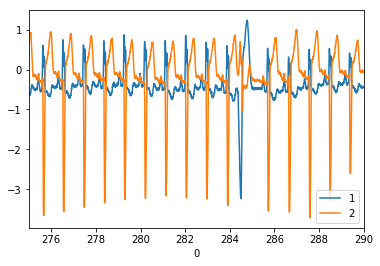

In [7]:
ecg_data.plot(x = 0, y = [1,2])
plt.show()


## Data Preprocessing

In [8]:
from sklearn.preprocessing import StandardScaler


In [9]:
scaler = StandardScaler()


### Splitting the data into training and test data

In [10]:
# From the plots, the anomaly occurs for t>284.
train_data = ecg_data[ecg_data[0] < 283][[1,2]].values


In [11]:
scaler_fit = scaler.fit(train_data)


In [12]:
scaled_traindata = scaler_fit.transform(train_data)
scaled_testdata = scaler_fit.transform(ecg_data[len(train_data):][[1,2]].values)


### Creating Sequences for LSTM training

In [13]:
from tensorflow import data
from tensorflow import keras

In [14]:
scaled_data = np.vstack((scaled_traindata, scaled_testdata))

del scaled_traindata, scaled_testdata

       * dtype of the data needs to match the dtype of the input layer in the network

In [15]:
scaled_data.dtype


dtype('float64')

In [16]:
# converting to float32
scaled_data = scaled_data.astype('float32')
scaled_data.dtype


dtype('float32')

In [17]:
def sequencing_fn(data, n_timesteps = 200, n_outputs = 1):
    """
    data: type ndarray

    n_timesteps: number of timesteps for LSTM training

    n_outputs: number of outputs to train on

    returns X, y of the shape samplesize x timesteps x n_features x 1
    """
    n_size = len(data)
    
    assert n_size > n_timesteps + n_outputs, "Number of data points must be greater than n_timesteps + n_outputs"
    
    x_gen = keras.preprocessing.sequence.TimeseriesGenerator(data, data, length = n_timesteps, end_index = n_size-n_outputs-1, batch_size = n_size, reverse = False)

    y_gen = keras.preprocessing.sequence.TimeseriesGenerator(data, data, length = n_outputs, start_index = n_timesteps, end_index = n_size-1, batch_size=n_size, reverse = False)


    return np.expand_dims(x_gen[0][0], axis=-1), y_gen[0][0]


##### Testing

In [18]:
test_xy = np.arange(0,20).reshape(-1,2)
x,y = sequencing_fn(test_xy, n_timesteps=5,n_outputs=2)
print("Test data: ", test_xy)
print("X: ", x)
print("Y: ", y)

del test_xy

Test data:  [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
X:  [[[[ 0]
   [ 1]]

  [[ 2]
   [ 3]]

  [[ 4]
   [ 5]]

  [[ 6]
   [ 7]]

  [[ 8]
   [ 9]]]


 [[[ 2]
   [ 3]]

  [[ 4]
   [ 5]]

  [[ 6]
   [ 7]]

  [[ 8]
   [ 9]]

  [[10]
   [11]]]


 [[[ 4]
   [ 5]]

  [[ 6]
   [ 7]]

  [[ 8]
   [ 9]]

  [[10]
   [11]]

  [[12]
   [13]]]]
Y:  [[[10 11]
  [12 13]]

 [[12 13]
  [14 15]]

 [[14 15]
  [16 17]]]


##### End Testing

In [19]:
def create_dataset_fn(arr, n_timesteps=200, n_outputs=1):

    """
    arr: array of shape n_samples x features

    processes arr using the sequencing_fn and
    returns a Dataset with dictionary elements for multiple inputs and multiple outputs
    """

    sequences = sequencing_fn(arr, n_timesteps, n_outputs)

    return data.Dataset.from_tensor_slices(({'ecg_input_1': sequences[0][:,:,0], 'ecg_input_2': sequences[0][:,:,1]}, {'ecg_output_1': sequences[1][:,:,0], 'ecg_output_2': sequences[1][:,:,1]}))


##### Testing

In [20]:
test_xy = create_dataset_fn(scaled_data[:20], n_timesteps=3, n_outputs=2)

for i in test_xy.take(2):
    print(i)

del test_xy

({'ecg_input_1': <tf.Tensor: id=13, shape=(3, 1), dtype=float32, numpy=
array([[-0.9310163 ],
       [-0.89837146],
       [-0.9310163 ]], dtype=float32)>, 'ecg_input_2': <tf.Tensor: id=14, shape=(3, 1), dtype=float32, numpy=
array([[1.0124924],
       [1.0647855],
       [1.1054578]], dtype=float32)>}, {'ecg_output_1': <tf.Tensor: id=15, shape=(2,), dtype=float32, numpy=array([-0.89837146, -0.9310163 ], dtype=float32)>, 'ecg_output_2': <tf.Tensor: id=16, shape=(2,), dtype=float32, numpy=array([1.1228888, 1.1519406], dtype=float32)>})
({'ecg_input_1': <tf.Tensor: id=21, shape=(3, 1), dtype=float32, numpy=
array([[-0.89837146],
       [-0.9310163 ],
       [-0.89837146]], dtype=float32)>, 'ecg_input_2': <tf.Tensor: id=22, shape=(3, 1), dtype=float32, numpy=
array([[1.0647855],
       [1.1054578],
       [1.1228888]], dtype=float32)>}, {'ecg_output_1': <tf.Tensor: id=23, shape=(2,), dtype=float32, numpy=array([-0.9310163, -0.882049 ], dtype=float32)>, 'ecg_output_2': <tf.Tensor: id=24, s

##### End Testing

In [21]:
seq_len = 229
# no. of time steps in the sequence

n_outputs = 10
# no. of outputs to predict


In [22]:
train_dataset = create_dataset_fn(scaled_data[:1700], n_timesteps = seq_len,n_outputs=n_outputs)
validation_dataset = create_dataset_fn(scaled_data[1700:2000], n_timesteps = seq_len,n_outputs=n_outputs)
test_dataset = create_dataset_fn(scaled_data[2000:], n_timesteps=seq_len, n_outputs=n_outputs)

In [23]:
batchsize=16
train_dataset = train_dataset.batch(batch_size=batchsize, drop_remainder=True)
validation_dataset = validation_dataset.batch(batch_size=batchsize, drop_remainder=True)
test_dataset = test_dataset.batch(batch_size=batchsize, drop_remainder=True)

In [24]:
train_dataset = train_dataset.prefetch(buffer_size=data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=data.experimental.AUTOTUNE)

## LSTM Model

In [25]:
def model_fn(batch_size=16, lstm1 = 128, lstm2 = 64, batchnorm1 = True, batchnorm2 = True, dropout = 0.5, recurr_dropout=0.5, outputs = 1, training = True):
    
    input_1 = keras.Input(shape=(None,1), batch_size=batch_size, name='ecg_input_1', dtype='float32')
    input_2 = keras.Input(shape=(None,1), batch_size=batch_size, name='ecg_input_2', dtype='float32')

    lstm1_1 = keras.layers.LSTM(units = lstm1, return_sequences=True, stateful = False,name='ecg1_lstm1')(input_1)

    lstm1_2 = keras.layers.LSTM(units = lstm1, return_sequences=True, stateful = False, name='ecg2_lstm1')(input_2)

    if batchnorm1 == True:
        lstm1_1 = keras.layers.BatchNormalization(renorm=False)(lstm1_1)
        lstm1_2 = keras.layers.BatchNormalization(renorm=False)(lstm1_2)
    
    lstm2_1 = keras.layers.LSTM(units = lstm2, dropout=dropout, recurrent_dropout=recurr_dropout, name='ecg1_lstm2')(lstm1_1, training=training)

    lstm2_2 = keras.layers.LSTM(units = lstm2, dropout=dropout, recurrent_dropout=recurr_dropout, name='ecg2_lstm2')(lstm1_2, training=training)

    if batchnorm2 == True:
        lstm2_1 = keras.layers.BatchNormalization(renorm=False)(lstm2_1)
        lstm2_2 = keras.layers.BatchNormalization(renorm=False)(lstm2_2)

    merged_features = keras.layers.concatenate([lstm2_1, lstm2_2])

    output_1 = keras.layers.Dense(outputs, name = 'ecg_output_1')(merged_features)
    output_2 = keras.layers.Dense(outputs, name = 'ecg_output_2')(merged_features)

    model = keras.Model(inputs = [input_1, input_2], outputs = [output_1, output_2])

    return model



### Callbacks

In [26]:
callbck_list = []


In [27]:
##### Early Stopping
callbck_earlystopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=3,verbose=1)

callbck_list.append(callbck_earlystopping)

In [28]:
##### Learning Rate
callbck_learningrate = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

callbck_list.append(callbck_learningrate)

In [29]:
##### Saving Model
modelsave_filepath = 'saved_models'
if os.path.exists(modelsave_filepath):
    pass
else:
    os.mkdir(modelsave_filepath)

callbck_modelchkpt = keras.callbacks.ModelCheckpoint(filepath=modelsave_filepath + '/' +'model_{epoch}-{val_loss:0.3f}.h5', monitor='val_loss', verbose=1, save_best_only=True)
callbck_list.append(callbck_modelchkpt)


In [30]:
##### Tensorboard
tensorboard_filepath = 'logs'
if os.path.exists(tensorboard_filepath):
    pass
else:
    os.mkdir(tensorboard_filepath)

callbck_tensorboard = keras.callbacks.TensorBoard(log_dir=tensorboard_filepath, write_graph=False, update_freq='epoch')
callbck_list.append(callbck_tensorboard)


#### New model

In [31]:
model = model_fn(batch_size=batchsize, lstm1=128, lstm2=64, batchnorm1=True, batchnorm2=True, dropout=0.3, recurr_dropout=0.3, outputs=n_outputs, training=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ecg_input_1 (InputLayer)        [(16, None, 1)]      0                                            
__________________________________________________________________________________________________
ecg_input_2 (InputLayer)        [(16, None, 1)]      0                                            
__________________________________________________________________________________________________
ecg1_lstm1 (LSTM)               (16, None, 128)      66560       ecg_input_1[0][0]                
__________________________________________________________________________________________________
ecg2_lstm1 (LSTM)               (16, None, 128)      66560       ecg_input_2[0][0]                
______________________________________________________________________________________________

In [32]:
from IPython.display import SVG

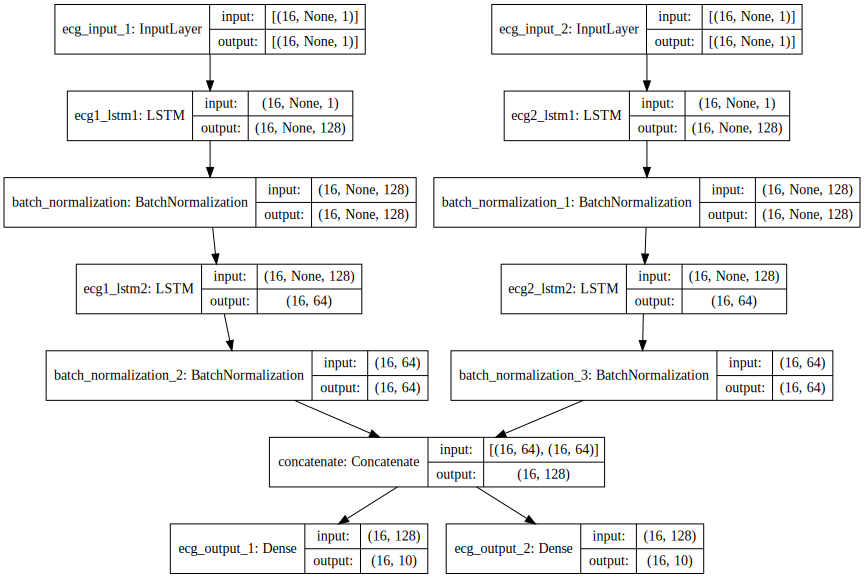

In [33]:
model_display = keras.utils.model_to_dot(model, show_shapes=True, dpi=72)
SVG(model_display.create(prog = 'dot', format='svg'))

In [34]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss={'ecg_output_1': 'mse', 'ecg_output_2': 'mse'}, metrics={'ecg_output_1': 'mse', 'ecg_output_2':'mse'})


In [ ]:
initial_epoch=0
final_epoch = 20
history = model.fit(train_dataset, epochs=final_epoch, verbose=1, callbacks=callbck_list, validation_data=validation_dataset, shuffle=False)


In [ ]:
#### Evaluating the model on test dataset
model.evaluate(test_dataset)

In [ ]:
del model
keras.backend.clear_session()

### Prediction

In [35]:
import tensorflow as tf

In [36]:
def pred_plot_fn(start_idx = 0, end_idx = 100, model_params = [128, 64, True, True], model_filepath = '/dir/model.h5', n_predictions = 1):

    """
    input_data type: array
                shape: n x 2
                dtype: has to match the input layer of model which is float32
                has to be scaled values
    
    model_filepath: model file (.h5 extension) to be used for prediction

    n_predictions: the number of time steps that will be predicted equals n_predictions x number of outputs the model predicts
    """

    input_data = scaled_data[start_idx:end_idx]

    input_data = tf.expand_dims(input_data, axis=0)
    # adding the batch dimension as the input_data has to be of 4 dimensions

    input_data = tf.expand_dims(input_data, axis=-1)
    # adding the feature dimension


    input_1 = input_data[:,:,0]
    input_2 = input_data[:,:,1]
    del input_data

    keras.backend.clear_session()
    new_model = model_fn(batch_size=1, lstm1=model_params[0], lstm2=model_params[1], batchnorm1=model_params[2], batchnorm2=model_params[3], training=False,outputs=n_outputs)
    new_model.load_weights(model_filepath)
    new_model.reset_states()
    

    for i in range(n_predictions):

        output_1, output_2 = new_model([input_1, input_2])

        input_1 = tf.concat([input_1, tf.expand_dims(output_1, axis=-1)], axis=1)
        input_2 = tf.concat([input_2, tf.expand_dims(output_2, axis=-1)], axis=1)

    del new_model
    keras.backend.clear_session()

    output_input = np.vstack((np.ravel(input_1), np.ravel(input_2))).T
    output_input = scaler_fit.inverse_transform(output_input)
    # Scaling to the original scale

    test_data = scaled_data[start_idx:end_idx+n_predictions*n_outputs]
    test_data = scaler_fit.inverse_transform(test_data)

    plt.plot(test_data[:,0], 'b', label = 'ecg1 sensor')
    plt.plot(test_data[:,1], 'r', label = 'ecg2 sensor')
    plt.plot(output_input[:,0], 'b--', label = 'ecg1 sensor prediction')
    plt.plot(output_input[:,1], 'r--', label = 'ecg2 sensor prediction')
    plt.legend(loc='best')
    plt.show()


#### Model parameters: lstm1 = 128, lstm2 = 64, batchnorm1 = False, batchnorm2 = True

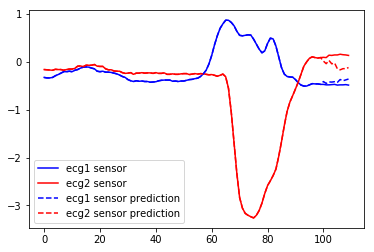

In [37]:
pred_plot_fn(start_idx=1000, end_idx=1100, model_params=[128,64,False, True], model_filepath='saved_models/model_5-0.419.h5', n_predictions=1)

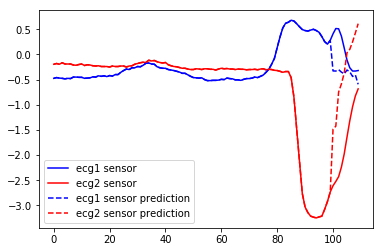

In [38]:
pred_plot_fn(start_idx=1900, end_idx=2000, model_params=[128,64,False, True], model_filepath='saved_models/model_5-0.419.h5', n_predictions=1)

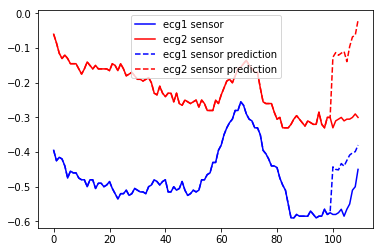

In [39]:
pred_plot_fn(start_idx=2100, end_idx=2200, model_params=[128,64,False, True], model_filepath='saved_models/model_5-0.419.h5', n_predictions=1)

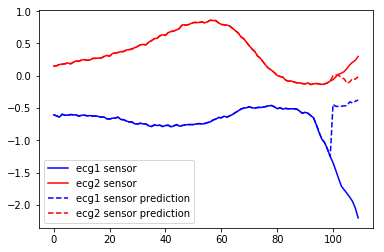

In [40]:
pred_plot_fn(start_idx=2250, end_idx=2350, model_params=[128,64,False, True], model_filepath='saved_models/model_5-0.419.h5', n_predictions=1)

#### Model parameters: lstm1 = 128, lstm2 = 64, batchnorm1 = True, batchnorm2 = True

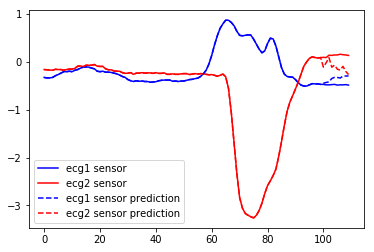

In [41]:
pred_plot_fn(start_idx=1000, end_idx=1100, model_params=[128,64,True, True], model_filepath='saved_models/model_6-0.369.h5', n_predictions=1)

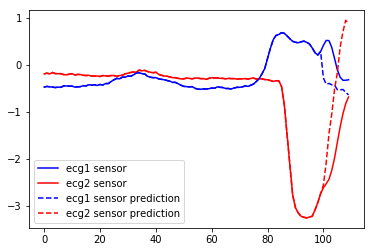

In [42]:
pred_plot_fn(start_idx=1900, end_idx=2000, model_params=[128,64,True, True], model_filepath='saved_models/model_6-0.369.h5', n_predictions=1)

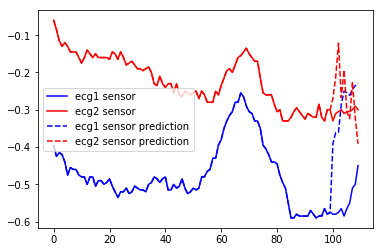

In [43]:
pred_plot_fn(start_idx=2100, end_idx=2200, model_params=[128,64,True, True], model_filepath='saved_models/model_6-0.369.h5', n_predictions=1)

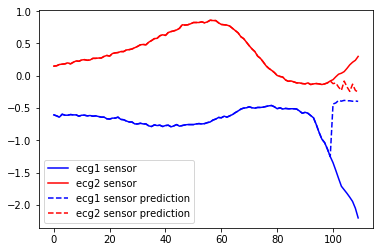

In [44]:
pred_plot_fn(start_idx=2250, end_idx=2350, model_params=[128,64,True, True], model_filepath='saved_models/model_6-0.369.h5', n_predictions=1)

#### Model parameters: lstm1 = 512, lstm2 = 256, batchnorm1 = True, batchnorm2 = True

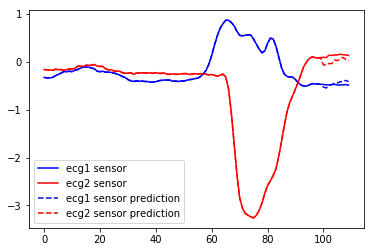

In [45]:
pred_plot_fn(start_idx=1000, end_idx=1100, model_params=[512,256,True, True], model_filepath='saved_models/model_8-0.535.h5', n_predictions=1)

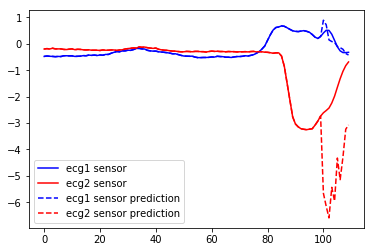

In [46]:
pred_plot_fn(start_idx=1900, end_idx=2000, model_params=[512,256,True, True], model_filepath='saved_models/model_8-0.535.h5', n_predictions=1)

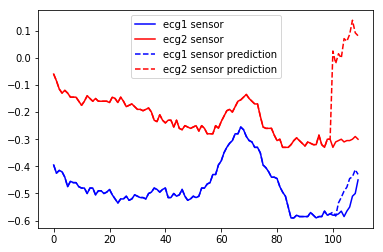

In [47]:
pred_plot_fn(start_idx=2100, end_idx=2200, model_params=[512,256,True, True], model_filepath='saved_models/model_8-0.535.h5', n_predictions=1)

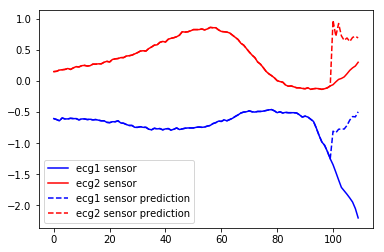

In [48]:
pred_plot_fn(start_idx=2250, end_idx=2350, model_params=[512,256,True, True], model_filepath='saved_models/model_8-0.535.h5', n_predictions=1)
